<a href="https://colab.research.google.com/github/stomioka/phuse-tumor-ml/blob/master/05_fnn_tumor_prediction_sites_central_google_cola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Response criteria prediction for tumor with neural networks

Sam Tomioka<br>
2019-10-13

Same data used in [notebook3](03-tumor_prediction-sites-central.ipynb) will be used here. 

- Model based on `central`+`site` with 85% of data from each. Test on remaining `central` assessments, Test on remaining `site` assessments independently.

In [0]:
#!pip install git+git://github.com/andirs/impyte.git
#!pip install xgboost 

!git clone https://github.com/stomioka/phuse-tumor-ml.git
!pip install git+git://github.com/andirs/impyte.git
!mv phuse-tumor-ml phuse_tumor_ml

Cloning into 'phuse-tumor-ml'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 98 (delta 44), reused 70 (delta 17), pack-reused 0
Unpacking objects: 100% (98/98), done.
  Cloning git://github.com/andirs/impyte.git to /tmp/pip-req-build-g4ctgx0e
  Running command git clone -q git://github.com/andirs/impyte.git /tmp/pip-req-build-g4ctgx0e
  Created wheel for impyte: filename=impyte-0.1.0-cp36-none-any.whl size=21388 sha256=2cb3c0b81b2db9b6a7d6a47bb8e3fc211e3adf9aaa124a81ff409b793f319958
  Stored in directory: /tmp/pip-ephem-wheel-cache-ytfl4mo2/wheels/65/16/30/1a24d053bf050146af36c12fdca5e3f2362d892226909931e4
Successfully built impyte


In [0]:
import os
os.chdir('phuse_tumor_ml/notebooks')
from lib.myutil import *
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.train import *
print('tensorflow version: {}'.format(tf.__version__))

import sklearn
from sklearn.metrics import accuracy_score,roc_curve, auc
print('sklearn version: {}'.format(sklearn.__version__))
import matplotlib.pyplot as plt
%matplotlib inline

tf.enable_eager_execution()

#tf.keras.backend.clear_session() 

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


tensorflow version: 1.15.0-rc3
sklearn version: 0.21.3


In [0]:
central, site=load_data()

tr_x, tr_y, ts_x, ts_y, ts_x2, ts_y2 = generate_tr_ts(df1=central, df2=site, m=3, method=None, h=3000, seed=2019)

In [0]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
tr_y = encoder.fit_transform(tr_y)
ts_y = encoder.fit_transform(ts_y)
ts_y2 = encoder.fit_transform(ts_y2)

In [0]:
tr_x.shape, tr_y.shape

((1373, 7), (1373, 5))

In [0]:
tf.keras.backend.clear_session() 
i = Input(shape=(7,),name='recest')
x = Dense(64, activation='relu', name='dense_1')(i)
x = Dense(32, activation='relu', name='dense_2')(x)
x = Dense(32, activation='relu', name='dense_3')(x)
x = Dense(16, activation='relu', name='dense_4')(x)
outputs = Dense(5, activation='softmax', name='pred')(x)

model = Model(i, outputs)
opt = AdamOptimizer(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
recest (InputLayer)          [(None, 7)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
pred (Dense)                 (None, 5)                 85        
Total params: 4,261
Trainable params: 4,261
Non-trainable params: 0
___________________________________________________________

In [0]:
x_train, x_vl, y_train, y_vl = train_test_split(tr_x, tr_y, test_size=0.20, random_state=2019)
history = model.fit(x_train, y_train,
                    batch_size=16,
                    epochs=200,

                    validation_data=(x_vl, y_vl))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1098 samples, validate on 275 samples
Epoch 1/200
1098/1098 [==============================] - 1s 841us/sample - loss: 1.3851 - acc: 0.3634 - val_loss: 1.0901 - val_acc: 0.5527
Epoch 2/200
1098/1098 [==============================] - 0s 139us/sample - loss: 0.8675 - acc: 0.6366 - val_loss: 0.7152 - val_acc: 0.7382
Epoch 3/200
1098/1098 [==============================] - 0s 137us/sample - loss: 0.6480 - acc: 0.7623 - val_loss: 0.6376 - val_acc: 0.7709
Epoch 4/200
1098/1098 [==============================] - 0s 162us/sample - loss: 0.5867 - acc: 0.7741 - val_loss: 0.5865 - val_acc: 0.7673
Epoch 5/200
1098/1098 [==============================] - 0s 218us/sample - loss: 0.5462 - acc: 0.7914 - val_loss: 0.5943 - val_acc: 0.7564
Epoch 6/200
1098/1098 [==============================] - 0s 271us/sample - loss: 0.5203 - acc: 0.7969 - val_loss: 0.5186 - val_acc: 0.7964
Epoch 7/200
1098/1098 [==

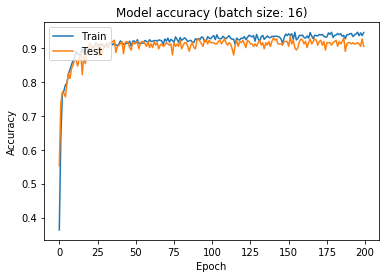

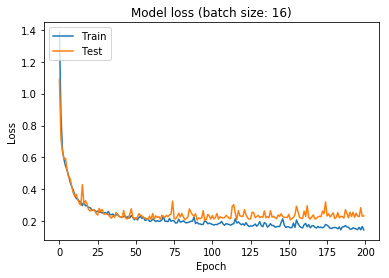

In [0]:
plot_hist(history)

In [0]:
results1=model.evaluate(ts_x, ts_y, batch_size=32)
print('\nm=3, test=C\n test loss: {}\n  test acc: {}'.format(results1[0],results1[1]))

138/138 [==============================] - 0s 537us/sample - loss: 0.4939 - acc: 0.8768

m=3, test=C
 test loss: 0.49386031671926595
  test acc: 0.8768116235733032


In [0]:
results2=model.evaluate(ts_x2, ts_y2, batch_size=32)
print('\nm=3, test=D\n test loss: {}\n  test acc: {}'.format(results2[0],results2[1]))

104/104 [==============================] - 0s 311us/sample - loss: 0.2709 - acc: 0.9712

m=3, test=D
 test loss: 0.27093212879621065
  test acc: 0.9711538553237915


## check where model did not predict correctly

In [ ]:
_, _, ts_x_df, ts_y_lbl, ts_x2_df, ts_y2_lbl = generate_tr_ts(df1=central, df2=site, m=3, method=None, h=3000, seed=2019, normalize=False)

In [ ]:
def prediction(encoder, model, test_x):
    pred=model.predict(test_x)
    return encoder.inverse_transform(np.round(pred))
def return_predict(encoder, model, test_x, test_y):
    pred=prediction(encoder, model, test_x)
    results=[pred==true for pred, true in list(zip(pred,test_y))]
    return results

In [ ]:
ts_x_df['Label']=ts_y_lbl['TRGRESP']
ts_x_df['Pred']=prediction(encoder, model, ts_x)
ts_x_df['Correct']=return_predict(encoder, model, ts_x, ts_y_lbl['TRGRESP'])
ts_x_df

In [ ]:
ts_x2_df['Label']=ts_y2_lbl['TRGRESP']
ts_x2_df['Pred']=prediction(encoder, model, ts_x2)
ts_x2_df['Correct']=return_predict(encoder, model, ts_x2, ts_y2_lbl['TRGRESP'])
ts_x2_df